In [1]:
import homcloud.interface as hc
import numpy as np
from ase.io import iread 



まずデータの情報を読み込み、処理しやすい形にします

In [2]:
samples=iread('test.xyz',format='extxyz')

atoms_total=[]
for _ in samples:
    atoms_total.append(_)



データの個数を確認しましょう

In [3]:
len(atoms_total)

3366

3000個以上データがあるのですが、すべてを使うと解析が大変なので、一部のデータを抜き出します

In [4]:
atoms=atoms_total[:400]

このデータは、アモルファスカーボンの第一原理計算結果が収められています。いくつかの構造を使ってパーシステンス図を書いてみましょう

In [5]:
sample1=atoms[0]

このようにしてやると、sample1には最初のデータが入ります。データの形式は、ASEのAtomsオブジェクトです。これは、原子の位置や種類、セルの大きさなどを持っています。

In [6]:
sample1

Atoms(symbols='C216', pbc=True, cell=[10.717036443, 10.717036443, 10.717036443], forces=..., calculator=SinglePointCalculator(...))

また、このデータセット特有の情報として、`info`という属性があります。これは、密度やどういった状態の構造かという追加の情報が入っています。

In [7]:

sample1.info

{'energy': -1970.32638997,
 'free_energy': -1970.57075924,
 'process': 'quench2',
 'density': 3.5}

では早速パーシステンス図を計算してみましょう。今回の系は、原子数が256個と少なく、ユニットセルもあまり大きくないので、周期境界条件を入れて計算を行います。

In [8]:


pd1_sample1=hc.PDList.from_alpha_filtration(sample1.positions,
                                    periodicity=[(0, sample1.cell[0,0]), (0, sample1.cell[1,1]), (0, sample1.cell[2,2])],
                                    save_boundary_map=True).dth_diagram(1)
pd1_sample1.histogram().plot(colorbar={"type": "log"})

OverflowError: cannot convert float infinity to integer

In [ ]:
sample2=atoms[156]

sample2.info

{'energy': -1657.61773265,
 'free_energy': -1659.14570748,
 'process': 'buffer_high',
 'density': 2.6}

In [ ]:


pd1_sample2=hc.PDList.from_alpha_filtration(sample2.positions,
                                    periodicity=[(0, sample2.cell[0,0]), (0, sample2.cell[1,1]), (0, sample2.cell[2,2])],
                                    save_boundary_map=True).dth_diagram(1)
pd1_sample2.histogram().plot(colorbar={"type": "log"})

OverflowError: cannot convert float infinity to integer

エネルギーや密度が異なるとパーシステンス図もかなり異なってくることがわかります。ということは、パーシステンス図からエネルギーを予測することができそう、ということが自然と期待されます。

パーシステンス図を回帰モデルの入力にするためには、ベクトルの形に変換する必要があります。その最も典型的な方法がPersistent imageというものです。

In [ ]:
mesh_count=128
sigma=0.08
weight='none'
vectorize_spec = hc.PIVectorizerMesh((0, 4), mesh_count, sigma=sigma, weight=weight)

vect_sample1=vectorize_spec.vectorize(pd1_sample1)

できたベクトルのサイズを確認してみましょう

In [ ]:
vect_sample1.shape

(8256,)

実際にパーシステンス図がどのように変換されたかは、以下のようにして確認できます

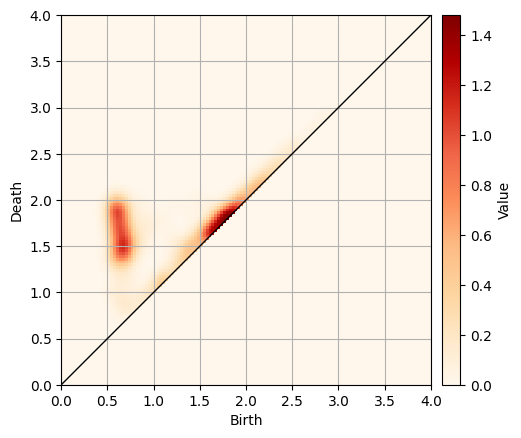

In [ ]:
hist_sample1=vectorize_spec.histogram_from_vector(vect_sample1).plot()

birth-death pairの分布をガウス関数でぼかして、それをメッシュ上で評価した形になっています。元々のベクトルは、対角線より上の部分を取り出し、それを平坦化しているので、１次元の配列の形状をしています。

では、すべてのデータに対して、ベクトルを作成してみましょう。回帰する対象のエネルギーも同時に収集するようにします

In [ ]:
vectors=[]
energies=[]

from tqdm import tqdm
for atom in tqdm(atoms):
    pd1=hc.PDList.from_alpha_filtration(atom.positions,
                                    periodicity=[(0, atom.cell[0,0]), (0, atom.cell[1,1]), (0, atom.cell[2,2])],
                                    save_boundary_map=True).dth_diagram(1)
    vect=vectorize_spec.vectorize(pd1)
    vectors.append(vect)
    energies.append(atom.info['energy'])


vectors=np.array(vectors)
energies=np.array(energies)

100%|██████████| 400/400 [02:01<00:00,  3.28it/s]


In [ ]:
vectors.shape, energies.shape

((400, 8256), (400,))

手始めにシンプルなRidge回帰を試してみましょう

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(vectors, energies, test_size=0.2, random_state=42)

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
ridge=Ridge(alpha=1.0)

ridge.fit(X_train, y_train)
ridge.score(X_test, y_test)

0.9917785351266643

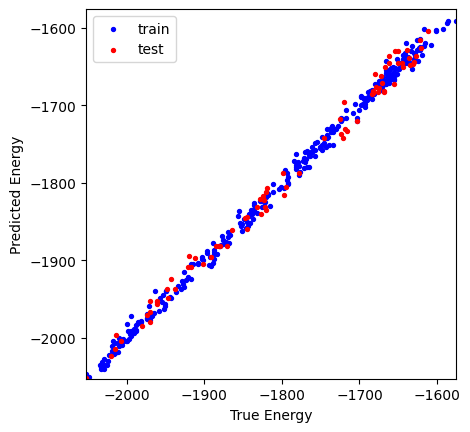

In [ ]:
import matplotlib.pyplot as plt

plt.gca().set_aspect('equal', adjustable='box')
min=energies.min()
max=energies.max()
plt.xlim(min,max)
plt.ylim(min,max)
plt.scatter(y_train, ridge.predict(X_train),c='b',s=8,label='train')
plt.scatter(y_test, ridge.predict(X_test),c='r',s=8,label='test')
plt.xlabel('True Energy')
plt.ylabel('Predicted Energy')
plt.legend()
plt.show()

Ridge回帰でかなり良い精度で回帰できています。

ではモデルがどこのbirth-death pairを見てエネルギーを予測しているかを可視化してみましょう

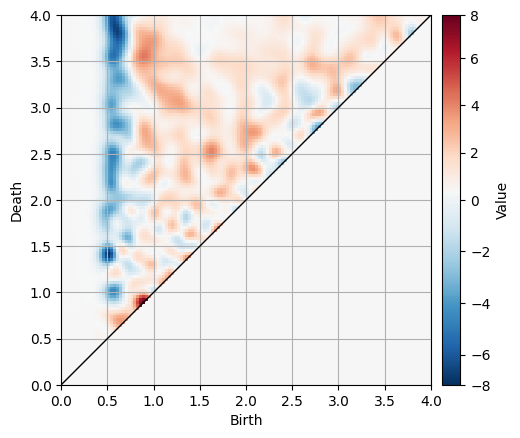

In [ ]:
vectorize_spec.histogram_from_vector(ridge.coef_).plot(colorbar={"type":"linear-midpoint", "midpoint": 0})

birth=0.5付近での縦線上にbirth-death pairが発現すると、エネルギーが低くなっている、そこから外れた点があるとエネルギーが高くなっているとモデルが判定しています。アモルファスにおけるパーシステンス図で縦に伸びる線は、アモルファスの中距離秩序を反映している場合が多く、「アモルファスらしい」構造はエネルギーが低く、液体的な構造はエネルギーが高いと判定しているようです。